Dataset length: 1240000

Metrics for System Size 12 (n=500000):
  MSE: 0.000036
  MAE: 0.004017
  MAPE: 13817132.81%

Metrics for System Size 6 (n=100000):
  MSE: 0.000019
  MAE: 0.002957
  MAPE: 17362435.94%

Metrics for System Size 10 (n=350000):
  MSE: 0.000025
  MAE: 0.003259
  MAPE: 11799999.22%

Metrics for System Size 8 (n=200000):
  MSE: 0.000021
  MAE: 0.003088
  MAPE: 14170714.06%

Metrics for System Size 4 (n=60000):
  MSE: 0.000044
  MAE: 0.004346
  MAPE: 28376875.00%

Metrics for System Size 2 (n=30000):
  MSE: 0.000180
  MAE: 0.008783
  MAPE: 2247.89%


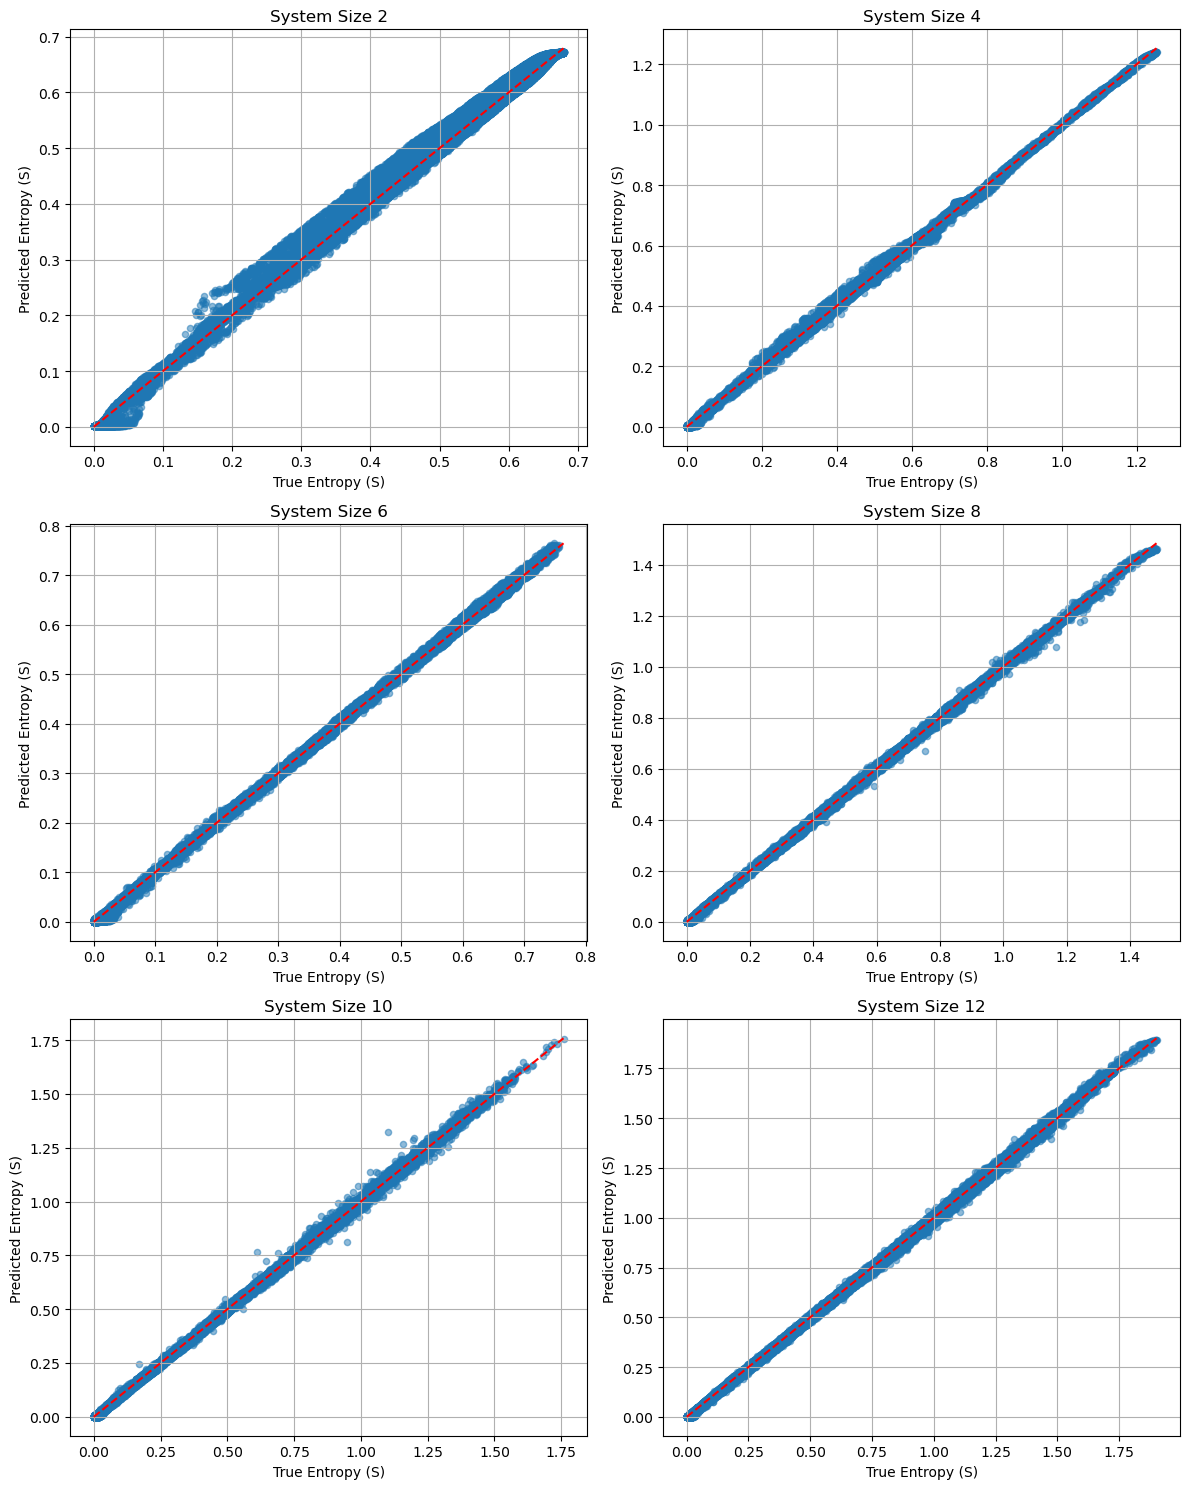

In [26]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from torch.serialization import safe_globals

# For interactive 3D plotting with Plotly
import plotly.graph_objects as go
from Train2_12 import ExperimentalGNN, SpinSystemDataset, PhysicalScaleAwareLoss

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'processed_dir': r'C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Testing\processed_experimentalrung1_6',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'hidden_channels': 1024,
    'num_layers': 8,
    'dropout_p': 0.4
}

# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=6, dropout_p=0.4):
    """
    Loads the model state dict (which includes BatchNorm running stats),
    then calls model.eval() to ensure those stats are used (frozen).
    """
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    # IMPORTANT: model.eval() so that BatchNorm uses stored running_mean / running_var
    model.eval()
    return model


def load_data():
    return SpinSystemDataset(root=CONFIG['processed_dir'])


# -----------------------------------------------------------------------------
# Evaluation Functions
# -----------------------------------------------------------------------------
def evaluate_by_system_size(model, dataset, N, batch_size=2048):
    """
    Evaluate the model's performance grouped by system size.
    Returns metrics and data for each system size separately.
    """
    subset = dataset[:N]
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Dictionaries to store results for each system size
    size_grouped_results = defaultdict(lambda: {
        'preds': [],
        'targets': [],
    })
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            
            # Convert tensors to numpy arrays and ensure they're 1D
            system_sizes = data.system_size.cpu().numpy().flatten()
            preds = pred.cpu().numpy().flatten()
            targets = data.y.cpu().numpy().flatten()
            
            # Group results by system size
            for i, size in enumerate(system_sizes):
                size = int(size)  # Convert to int for dictionary key
                size_grouped_results[size]['preds'].append(preds[i])
                size_grouped_results[size]['targets'].append(targets[i])
    
    # Convert lists to numpy arrays and calculate metrics for each system size
    metrics_by_size = {}
    for size, data in size_grouped_results.items():
        # Convert lists to numpy arrays
        for key in data:
            data[key] = np.array(data[key]).flatten()  # Ensure 1D arrays
        
        mse, mae, mape = calculate_metrics(data['preds'], data['targets'])
        metrics_by_size[size] = {
            'mse': mse,
            'mae': mae,
            'mape': mape,
            'count': len(data['preds'])
        }
        
        print(f"\nMetrics for System Size {size} (n={metrics_by_size[size]['count']}):")
        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  MAPE: {mape:.2f}%")
    
    return size_grouped_results, metrics_by_size

def calculate_metrics(preds, targets):
    """Calculate various error metrics."""
    # Ensure inputs are 1D arrays
    preds = np.asarray(preds).flatten()
    targets = np.asarray(targets).flatten()
    
    mse = mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    # Avoid division by zero in MAPE calculation
    mape = np.mean(np.abs((preds - targets) / np.maximum(np.abs(targets), 1e-10))) * 100
    return mse, mae, mape

# -----------------------------------------------------------------------------
# Enhanced Plotting Functions
# -----------------------------------------------------------------------------
def plot_results_by_size(size_grouped_results):
    """Plot true vs predicted entropy for each system size."""
    num_sizes = len(size_grouped_results)
    cols = min(2, num_sizes)
    rows = (num_sizes + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(-1, 1) if cols == 1 else axes.reshape(1, -1)
    
    for idx, (size, data) in enumerate(sorted(size_grouped_results.items())):
        row, col = idx // cols, idx % cols
        ax = axes[row, col]
        
        ax.scatter(data['targets'], data['preds'], alpha=0.5, s=20)
        
        # Add diagonal line
        min_val = min(data['targets'].min(), data['preds'].min())
        max_val = max(data['targets'].max(), data['preds'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        ax.set_xlabel('True Entropy (S)')
        ax.set_ylabel('Predicted Entropy (S)')
        ax.set_title(f'System Size {size}')
        ax.grid(True)
    
    # Remove empty subplots
    for idx in range(len(size_grouped_results), rows*cols):
        row, col = idx // cols, idx % cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.savefig('1-6_results', dpi=300, bbox_inches='tight')
    plt.show()
    


# -----------------------------------------------------------------------------
# Main Function
# -----------------------------------------------------------------------------
def main():
    model_path = 'best_model_rung1_6.pth'
    N = 100000000  # Number of graphs to evaluate
    
    dataset = load_data()
    print(f"Dataset length: {len(dataset)}")
    
    model = load_trained_model(model_path)
    
    # Evaluate and plot results grouped by system size
    size_grouped_results, metrics_by_size = evaluate_by_system_size(model, dataset, N)
    
    # Plot results for each system size
    plot_results_by_size(size_grouped_results)


if __name__ == "__main__":
    main()

Building Hamiltonian...
Dimension of Hilbert: 2^16 = 65536
Ground-state energy: -58.624473
Exact Von Neumann Entropy (subsystem A): 1.001959
Exact Classical MI: 0.688309
GNN-predicted VNE (no cutoff): 0.945145


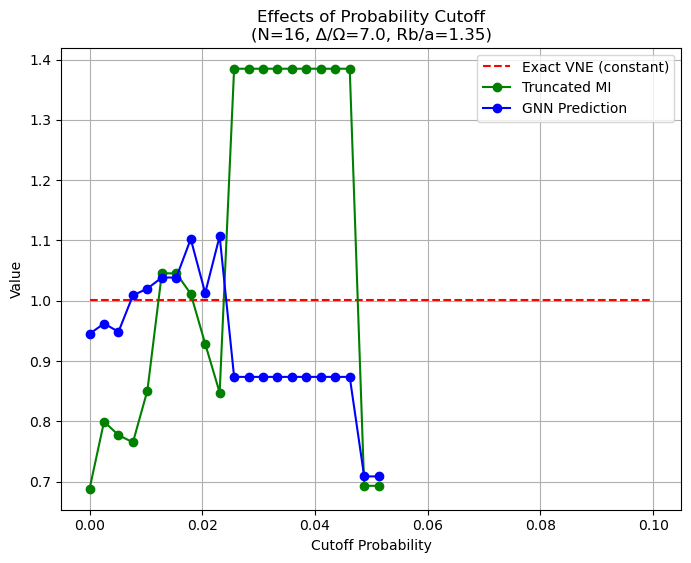

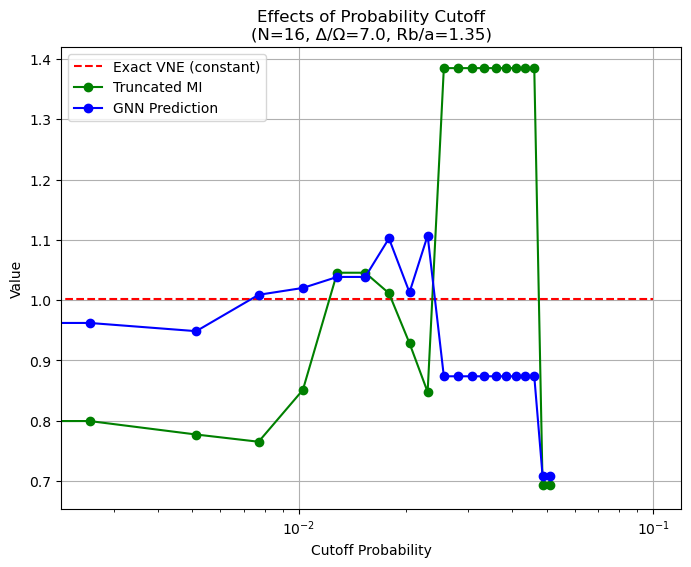

In [14]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
import netket as nk
from netket.operator.spin import sigmax, sigmaz, sigmam, sigmap

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch.serialization import safe_globals

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from Train2_12 import ExperimentalGNN


# ---------------------------------------------------------------------
# Helper functions for exact calculations
# ---------------------------------------------------------------------
def get_symmetric_partition_indices(Nx, Ny):
    N = Nx * Ny
    sites = [(x, y) for x in range(Nx) for y in range(Ny)]
    mid_y = Ny / 2
    A_indices = [i for i, (xx, yy) in enumerate(sites) if yy < mid_y]
    return sorted(A_indices)

def reshape_for_subsystem(psi, A_indices, N):
    A_set = set(A_indices)
    B_indices = [i for i in range(N) if i not in A_set]
    A_map = {spin: pos for pos, spin in enumerate(A_indices)}
    B_map = {spin: pos for pos, spin in enumerate(B_indices)}

    N_A = len(A_indices)
    N_B = N - N_A
    psi_reshaped = np.zeros((2**N_A, 2**N_B), dtype=psi.dtype)

    for global_idx in range(2**N):
        tmp = global_idx
        i_A = 0
        i_B = 0
        for spin in range(N):
            bit = (tmp & 1)
            tmp >>= 1
            if spin in A_map:
                i_A |= (bit << A_map[spin])
            else:
                i_B |= (bit << B_map[spin])
        psi_reshaped[i_A, i_B] = psi[global_idx]

    return psi_reshaped

def calculate_von_neumann_entropy(psi, A_indices, N):
    psi_2D = reshape_for_subsystem(psi, A_indices, N)
    U, s, Vh = np.linalg.svd(psi_2D, full_matrices=False)
    s2 = s**2
    s2 /= s2.sum() + 1e-14
    vne = -np.sum(s2 * np.log(s2 + 1e-14))
    return vne

def calculate_classical_MI(psi, A_indices, N):
    B_indices = [i for i in range(N) if i not in A_indices]
    probabilities = np.abs(psi)**2
    
    p_A = np.zeros(2**len(A_indices))
    p_B = np.zeros(2**len(B_indices))

    for global_idx in range(2**N):
        prob = probabilities[global_idx]
        if prob < 1e-14:
            continue
        bin_str = format(global_idx, f"0{N}b")
        A_part = ''.join(bin_str[i] for i in A_indices)
        B_part = ''.join(bin_str[i] for i in B_indices)
        A_state = int(A_part, 2)
        B_state = int(B_part, 2)
        p_A[A_state] += prob
        p_B[B_state] += prob

    MI = 0.0
    for global_idx in range(2**N):
        prob = probabilities[global_idx]
        if prob < 1e-14:
            continue
        bin_str = format(global_idx, f"0{N}b")
        A_part = ''.join(bin_str[i] for i in A_indices)
        B_part = ''.join(bin_str[i] for i in B_indices)
        A_state = int(A_part, 2)
        B_state = int(B_part, 2)
        MI += prob * np.log(prob / (p_A[A_state] * p_B[B_state] + 1e-14) + 1e-14)
    return float(MI)

# ---------------------------------------------------------------------
# Minimal wavefunction -> PyG Data logic
# ---------------------------------------------------------------------
def calculate_quantum_correlations_optimized(state_indices, state_probs, N):
    from itertools import combinations
    correlations = np.zeros((N, N), dtype=np.float32)
    states = np.array(state_indices, dtype=np.int64)
    probs = np.array(state_probs, dtype=np.float32)

    for i in range(N):
        mask = (states & (1 << i)) != 0
        correlations[i, i] = np.sum(probs[mask])

    for i, j in combinations(range(N), 2):
        mask = ((states & (1 << i)) != 0) & ((states & (1 << j)) != 0)
        corr = np.sum(probs[mask])
        connected_corr = corr - correlations[i, i]*correlations[j, j]
        correlations[i, j] = connected_corr
        correlations[j, i] = connected_corr
    return correlations

def create_edges_with_cutoff(positions, N, distance_cutoff=6):
    edges = []
    for i in range(N):
        for j in range(i + 1, N):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist <= distance_cutoff:
                edges.append([i, j])
    if edges:
        return np.array(edges, dtype=np.int64).T
    return np.zeros((2,0), dtype=np.int64)

def process_single_row(row_data):
    Nx = 2
    Ny = row_data['Ny']
    N = Nx * Ny
    distance_cutoff = 6.0
    
    positions = np.array([(col, row * 2) for row in range(Nx) for col in range(Ny)], dtype=np.float32)
    correlation_matrix = calculate_quantum_correlations_optimized(
        row_data['All_Indices'], row_data['All_Probabilities'], N
    )

    mask_str = row_data['Subsystem_Mask']
    mask = np.array([int(ch) for ch in mask_str], dtype=np.float32).reshape(-1, 1)

    node_features = np.concatenate([
        positions,
        correlation_matrix.diagonal().reshape(-1, 1),
        mask
    ], axis=1)

    edge_index = create_edges_with_cutoff(positions, N, distance_cutoff)
    if edge_index.size > 0:
        pos_i = positions[edge_index[0]]
        pos_j = positions[edge_index[1]]
        vec_ij = pos_j - pos_i
        dist_ij = np.linalg.norm(vec_ij, axis=1, keepdims=True) / np.sqrt(N)
        angle_ij = np.arctan2(vec_ij[:,1], vec_ij[:,0]).reshape(-1, 1)
        corr_values = correlation_matrix[edge_index[0], edge_index[1]].reshape(-1, 1)
        edge_attr = np.concatenate([angle_ij, corr_values, dist_ij], axis=1)
    else:
        edge_attr = np.zeros((0,3), dtype=np.float32)

    data_obj = Data(
        x=torch.tensor(node_features, dtype=torch.float32),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float32),
        y=torch.tensor([row_data['Von_Neumann_Entropy']], dtype=torch.float32),
        MI=torch.tensor([row_data['Classical_MI']], dtype=torch.float32),
        delta_over_omega=torch.tensor([row_data['Delta_over_Omega']], dtype=torch.float32),
        rb_over_a=torch.tensor([row_data['Rb_over_a']], dtype=torch.float32),
        system_size=torch.tensor([[N]], dtype=torch.float32),
        nA=torch.tensor([[mask.sum()]], dtype=torch.float32),
        nB=torch.tensor([[N - mask.sum()]], dtype=torch.float32),
    )
    return data_obj

# ---------------------------------------------------------------------
# Build Hamiltonian with the "1/4" factor in the Rydberg Interaction
# ---------------------------------------------------------------------
def build_rydberg_hamiltonian(Nx, Ny, Delta_over_Omega, Rb_over_a, R_cut=6.0):
    """
    Matches your snippet:  V_ij = (Rb_over_a^6)/(4 * r^6).
    """
    N = Nx * Ny
    positions = []
    for row in range(Nx):
        for col in range(Ny):
            positions.append((col, row * 2))  # same geometry as your code
    positions = np.array(positions, dtype=float)

    hi = nk.hilbert.Spin(s=1/2, N=N)
    sigmap_ops = [sigmap(hi, i) for i in range(N)]
    sigmam_ops = [sigmam(hi, i) for i in range(N)]
    sigmaz_ops = [sigmaz(hi, i) for i in range(N)]

    H = nk.operator.LocalOperator(hi)

    # Onsite terms
    for i in range(N):
        # (1/2)*(σ^+ + σ^-)
        H += 0.5 * (sigmap_ops[i] + sigmam_ops[i])
        # (Delta_over_Omega/2)*(σz - 1)
        H += (Delta_over_Omega/2) * (sigmaz_ops[i] - 1)

    # Interaction terms
    for i in range(N):
        for j in range(i+1, N):
            dx = positions[i,0] - positions[j,0]
            dy = positions[i,1] - positions[j,1]
            r = np.sqrt(dx*dx + dy*dy)
            if r <= R_cut:
                # Factor 1/4 in the denominator (plus r^6):
                V_ij = Rb_over_a**6 / (4.0 * (r**6 + 1e-14))
                H += V_ij * (sigmaz_ops[i] - 1) * (sigmaz_ops[j] - 1)

    sp_h = H.to_sparse()
    sp_h_csr = csr_matrix(sp_h)
    return sp_h_csr

def load_trained_gnn(model_path):
    model = ExperimentalGNN(hidden_channels=512, num_layers=6, dropout_p=0.4)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    return model



def main():
    # ------------------
    # Single parameters
    # ------------------
    Nx = 2
    Ny = 8
    Delta_over_Omega = 7.0
    Rb_over_a = 1.35
    R_cut = 6.0


    print("Building Hamiltonian...")
    H_csr = build_rydberg_hamiltonian(Nx, Ny, Delta_over_Omega, Rb_over_a, R_cut)
    N = Nx * Ny
    print(f"Dimension of Hilbert: 2^{N} = {2**N}")


    vals, vecs = eigsh(H_csr, k=1, which='SA')
    E_gs = vals[0]
    psi_gs = vecs[:,0]
    psi_gs /= np.linalg.norm(psi_gs)

    print(f"Ground-state energy: {E_gs:.6f}")

    A_indices = get_symmetric_partition_indices(Nx, Ny)
    vne_exact = calculate_von_neumann_entropy(psi_gs, A_indices, N)
    MI_exact = calculate_classical_MI(psi_gs, A_indices, N)
    print(f"Exact Von Neumann Entropy (subsystem A): {vne_exact:.6f}")
    print(f"Exact Classical MI: {MI_exact:.6f}")

    # Build Data object
    probabilities = np.abs(psi_gs)**2
    indices = np.arange(len(probabilities))
    mask = np.zeros(N, dtype=int)
    for idx in A_indices:
        mask[idx] = 1
    mask_str = ''.join(str(x) for x in mask)

    row_data_full = {
        'Ny': Ny,
        'Delta_over_Omega': Delta_over_Omega,
        'Rb_over_a': Rb_over_a,
        'Energy': E_gs,
        'All_Indices': indices.tolist(),
        'All_Probabilities': probabilities.tolist(),
        'Von_Neumann_Entropy': vne_exact,
        'Classical_MI': MI_exact,
        'Subsystem_Mask': mask_str
    }
    data_full = process_single_row(row_data_full)
    batch_full = Batch.from_data_list([data_full])

    # Load GNN
    model_path = "finetuned_model.pth"
    model = load_trained_gnn(model_path)
    with torch.no_grad():
        pred_vne_full = model(batch_full)
    print(f"GNN-predicted VNE (no cutoff): {float(pred_vne_full):.6f}")

    # Probability cutoffs
    cutoffs = np.linspace(0.0, 0.1, 40)
    classical_MIs = []
    gnn_preds = []

    for cval in cutoffs:
        keep_mask = (probabilities >= cval)
        if not np.any(keep_mask):
            classical_MIs.append(np.nan)
            gnn_preds.append(np.nan)
            continue
        truncated_probs = probabilities[keep_mask].copy()
        truncated_probs /= truncated_probs.sum() + 1e-14
        truncated_psi = np.sqrt(truncated_probs)

        truncated_indices = indices[keep_mask]
        psi_trunc_full = np.zeros_like(probabilities)
        psi_trunc_full[truncated_indices] = truncated_psi

        cur_MI = calculate_classical_MI(psi_trunc_full, A_indices, N)

        row_data_cut = {
            'Ny': Ny,
            'Delta_over_Omega': Delta_over_Omega,
            'Rb_over_a': Rb_over_a,
            'Energy': E_gs,
            'All_Indices': truncated_indices.tolist(),
            'All_Probabilities': truncated_probs.tolist(),
            'Von_Neumann_Entropy': vne_exact,  # "real" wavefunction's VNE is unchanged
            'Classical_MI': cur_MI,
            'Subsystem_Mask': mask_str
        }
        data_cut = process_single_row(row_data_cut)
        batch_cut = Batch.from_data_list([data_cut])
        with torch.no_grad():
            pred_vne_cut = model(batch_cut)
        classical_MIs.append(cur_MI)
        gnn_preds.append(float(pred_vne_cut))

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(cutoffs, [vne_exact]*len(cutoffs), 'r--', label='Exact VNE (constant)')
    plt.plot(cutoffs, classical_MIs, 'g-o', label='Truncated MI')
    plt.plot(cutoffs, gnn_preds, 'b-o', label='GNN Prediction')
    plt.xlabel("Cutoff Probability")
    plt.ylabel("Value")
    plt.title(f"Effects of Probability Cutoff\n(N={N}, Δ/Ω={Delta_over_Omega}, Rb/a={Rb_over_a})")
    plt.grid(True)
    plt.legend()
    plt.show()


    plt.figure(figsize=(8,6))
    plt.plot(cutoffs, [vne_exact]*len(cutoffs), 'r--', label='Exact VNE (constant)')
    plt.plot(cutoffs, classical_MIs, 'g-o', label='Truncated MI')
    plt.plot(cutoffs, gnn_preds, 'b-o', label='GNN Prediction')
    plt.xlabel("Cutoff Probability")
    plt.ylabel("Value")
    plt.title(f"Effects of Probability Cutoff\n(N={N}, Δ/Ω={Delta_over_Omega}, Rb/a={Rb_over_a})")
    plt.grid(True)
    plt.xscale('log')
    plt.legend()
    plt.show()
if __name__ == "__main__":
    main()
    

C:\Users\amssa\anaconda3\envs\env_name\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\amssa\anaconda3\envs\env_name\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


ERROR! Intel® Extension for PyTorch* needs to work with PyTorch 2.3.*, but PyTorch 2.5.1 is found. Please switch to the matching version and run again.
Dataset length: 1000
Metrics on 50000 graphs:
  MSE: 0.003023
  MAE: 0.036667
  MAPE: 207983.12%


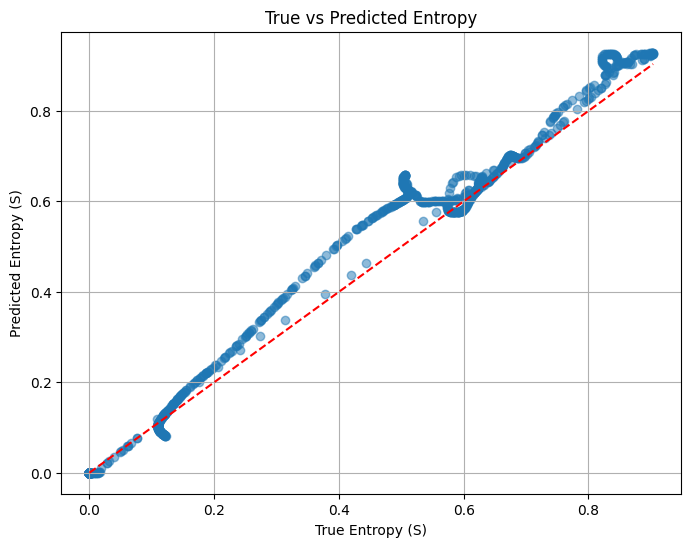

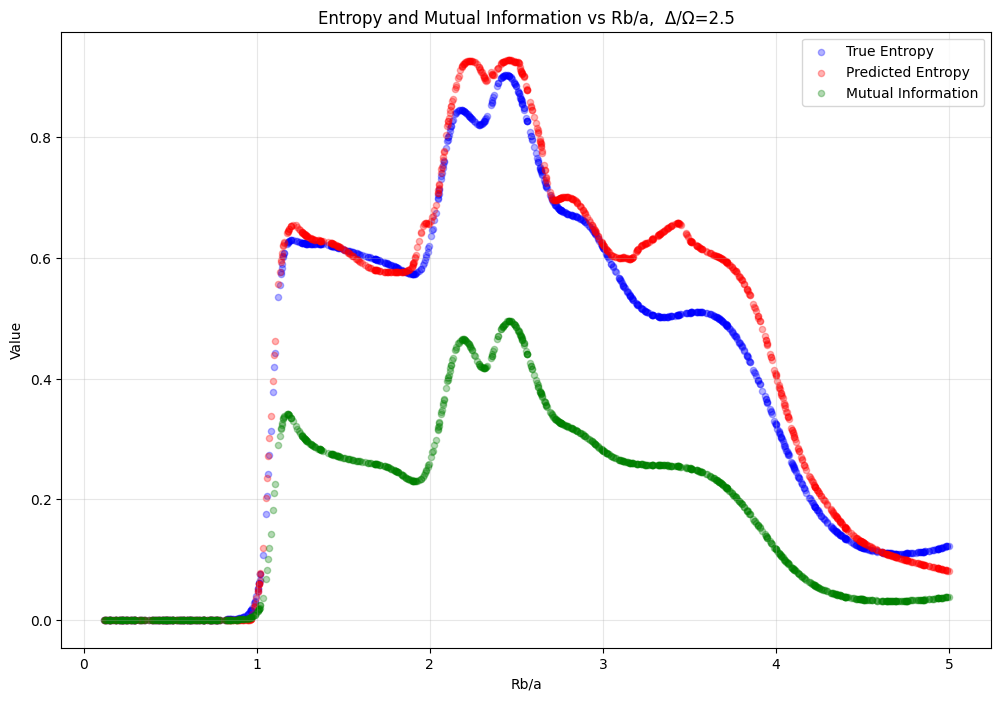

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from torch.serialization import safe_globals
from Train2_12 import ExperimentalGNN, SpinSystemDataset, PhysicalScaleAwareLoss

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'processed_dir': r'C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Testing\processed_Delta2.5_size8_r6',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'hidden_channels': 512,
    'num_layers': 8,
    'dropout_p': 0.4
}


def load_data():
    return SpinSystemDataset(root=CONFIG['processed_dir'])


# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=6, dropout_p=0.4):
    """
    Loads the model state dict (which includes BatchNorm running stats),
    then calls model.eval() to ensure those stats are used (frozen).
    """
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    # IMPORTANT: model.eval() so that BatchNorm uses stored running_mean / running_var
    model.eval()
    return model

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_on_subset(model, dataset, N, batch_size=2048):
    subset = dataset[:N]  # Evaluate on first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    all_targets = []
    all_rb_over_a = []
    all_delta_over_omega = []
    all_mutual_info = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            
            targets = data.y.squeeze()                        
            rb_over_a = data.rb_over_a.squeeze(-1)            
            delta_over_omega = data.delta_over_omega.squeeze(-1)
            mutual_info = data.MI.squeeze(-1)
            
            all_preds.append(pred.cpu())
            all_targets.append(targets.cpu())
            all_rb_over_a.append(rb_over_a.cpu())
            all_delta_over_omega.append(delta_over_omega.cpu())
            all_mutual_info.append(mutual_info.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_rb_over_a = torch.cat(all_rb_over_a).numpy()
    all_delta_over_omega = torch.cat(all_delta_over_omega).numpy()
    all_mutual_info = torch.cat(all_mutual_info).numpy()
    
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_preds - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics on {N} graphs:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return all_preds, all_targets, all_rb_over_a, all_delta_over_omega, all_mutual_info

# -----------------------------------------------------------------------------
# Plotting Functions
# -----------------------------------------------------------------------------
def plot_results(preds, targets):
    residuals = targets - preds
    abs_errors = np.abs(residuals)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Predicted Entropy (S)')
    plt.title('True vs Predicted Entropy')
    plt.grid(True)
    plt.show()

def plot_2d_values_vs_rb_a(rb_over_a, targets, preds, mutual_info, 
                                save_fig=False, fig_filename='2d_plot.png'):
    """
    Create a 2D plot showing true entropy, predicted entropy, and mutual information
    against delta/omega values.
    """
    plt.figure(figsize=(12, 8))
    

    sort_idx = np.argsort(rb_over_a)
    rb_over_a = rb_over_a[sort_idx]
    targets = targets[sort_idx]
    preds = preds[sort_idx]
    mutual_info = mutual_info[sort_idx]
    
    # Plot each series
    plt.scatter(rb_over_a, targets, alpha=0.3, label='True Entropy', color='blue', s=20)
    plt.scatter(rb_over_a, preds, alpha=0.3, label='Predicted Entropy', color='red', s=20)
    plt.scatter(rb_over_a, mutual_info, alpha=0.3, label='Mutual Information', color='green', s=20)
    
    
    plt.xlabel('Rb/a')
    plt.ylabel('Value')
    plt.title('Entropy and Mutual Information vs Rb/a,  Δ/Ω=2.5')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_fig:
        plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {fig_filename}")
    else:
        plt.show()

def main():
    # Point to the model you trained with BatchNorm
    model_path = 'finetuned_model_9-10.pth'
    N = 50000  # Number of graphs to evaluate
    
    dataset = load_data()
    print(f"Dataset length: {len(dataset)}")
    
    # Load the trained model, which has BN statistics in state_dict
    model = load_trained_model(model_path)
    preds, targets, rb_over_a, delta_over_omega, mutual_info = evaluate_on_subset(model, dataset, N)
    
    # Create both plots
    plot_results(preds, targets)
    plot_2d_values_vs_rb_a(rb_over_a, targets, preds, mutual_info, save_fig=False)

if __name__ == "__main__":
    main()

Dataset length: 1000
Metrics on 50000 graphs:
  MSE: 0.002912
  MAE: 0.032829
  MAPE: 986831.12%


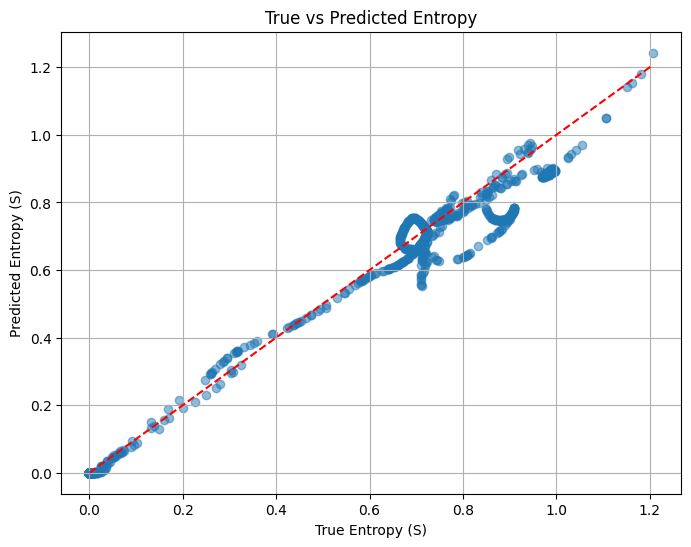

Plot saved as 2d_plot.png


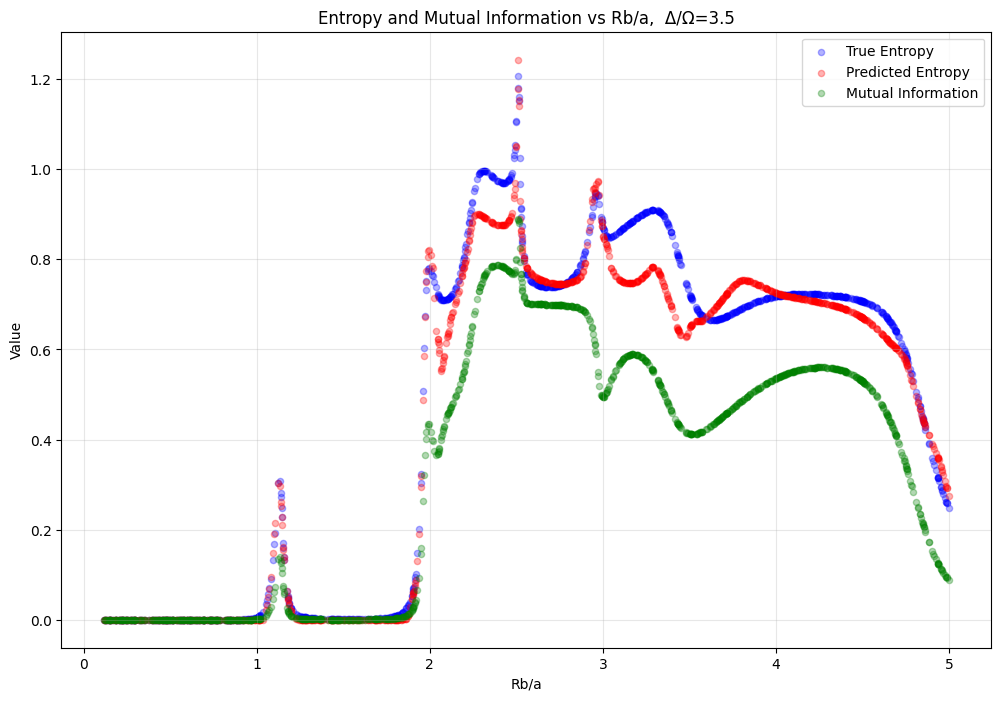

In [45]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from torch.serialization import safe_globals
from Train2_12 import ExperimentalGNN, SpinSystemDataset, PhysicalScaleAwareLoss

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'processed_dir': r'C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Testing\processed_Delta3.5_size9_r6',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'hidden_channels': 512,
    'num_layers': 8,
    'dropout_p': 0.4
}


def load_data():
    return SpinSystemDataset(root=CONFIG['processed_dir'])


# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=6, dropout_p=0.4):
    """
    Loads the model state dict (which includes BatchNorm running stats),
    then calls model.eval() to ensure those stats are used (frozen).
    """
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    # IMPORTANT: model.eval() so that BatchNorm uses stored running_mean / running_var
    model.eval()
    return model

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_on_subset(model, dataset, N, batch_size=2048):
    subset = dataset[:N]  # Evaluate on first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    all_targets = []
    all_rb_over_a = []
    all_delta_over_omega = []
    all_mutual_info = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            
            targets = data.y.squeeze()                        
            rb_over_a = data.rb_over_a.squeeze(-1)            
            delta_over_omega = data.delta_over_omega.squeeze(-1)
            mutual_info = data.MI.squeeze(-1)
            
            all_preds.append(pred.cpu())
            all_targets.append(targets.cpu())
            all_rb_over_a.append(rb_over_a.cpu())
            all_delta_over_omega.append(delta_over_omega.cpu())
            all_mutual_info.append(mutual_info.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_rb_over_a = torch.cat(all_rb_over_a).numpy()
    all_delta_over_omega = torch.cat(all_delta_over_omega).numpy()
    all_mutual_info = torch.cat(all_mutual_info).numpy()
    
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_preds - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics on {N} graphs:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return all_preds, all_targets, all_rb_over_a, all_delta_over_omega, all_mutual_info

# -----------------------------------------------------------------------------
# Plotting Functions
# -----------------------------------------------------------------------------
def plot_results(preds, targets):
    residuals = targets - preds
    abs_errors = np.abs(residuals)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Predicted Entropy (S)')
    plt.title('True vs Predicted Entropy')
    plt.grid(True)
    plt.show()

def plot_2d_values_vs_rb_a(rb_over_a, targets, preds, mutual_info, 
                                save_fig=False, fig_filename='2d_plot.png'):
    """
    Create a 2D plot showing true entropy, predicted entropy, and mutual information
    against delta/omega values.
    """
    plt.figure(figsize=(12, 8))
    

    sort_idx = np.argsort(rb_over_a)
    rb_over_a = rb_over_a[sort_idx]
    targets = targets[sort_idx]
    preds = preds[sort_idx]
    mutual_info = mutual_info[sort_idx]
    
    # Plot each series
    plt.scatter(rb_over_a, targets, alpha=0.3, label='True Entropy', color='blue', s=20)
    plt.scatter(rb_over_a, preds, alpha=0.3, label='Predicted Entropy', color='red', s=20)
    plt.scatter(rb_over_a, mutual_info, alpha=0.3, label='Mutual Information', color='green', s=20)
    
    
    plt.xlabel('Rb/a')
    plt.ylabel('Value')
    plt.title('Entropy and Mutual Information vs Rb/a,  Δ/Ω=3.5')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_fig:
        plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {fig_filename}")
    else:
        plt.show()

def main():
    # Point to the model you trained with BatchNorm
    model_path = 'finetuned_model_9-10_1.5k.pth'
    N = 50000  # Number of graphs to evaluate
    
    dataset = load_data()
    print(f"Dataset length: {len(dataset)}")
    
    # Load the trained model, which has BN statistics in state_dict
    model = load_trained_model(model_path)
    preds, targets, rb_over_a, delta_over_omega, mutual_info = evaluate_on_subset(model, dataset, N)
    
    # Create both plots
    plot_results(preds, targets)
    plot_2d_values_vs_rb_a(rb_over_a, targets, preds, mutual_info, save_fig=True)

if __name__ == "__main__":
    main()

Dataset length: 1056
Metrics on 50000 graphs:
  MSE: 0.000553
  MAE: 0.017581
  MAPE: 3738552.34%


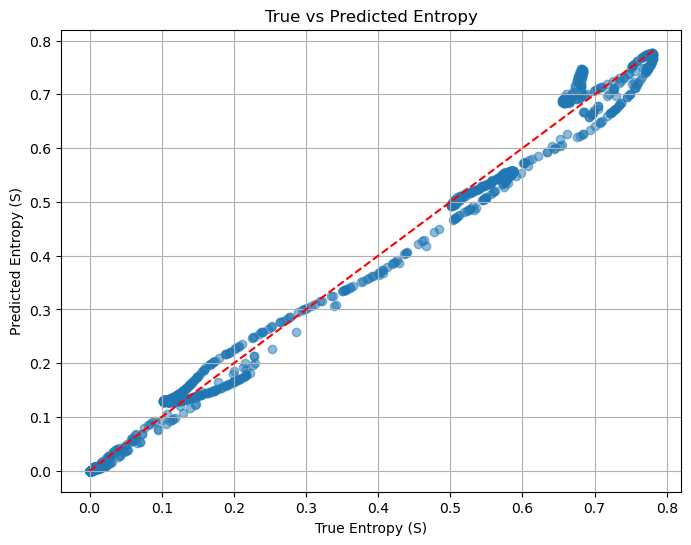

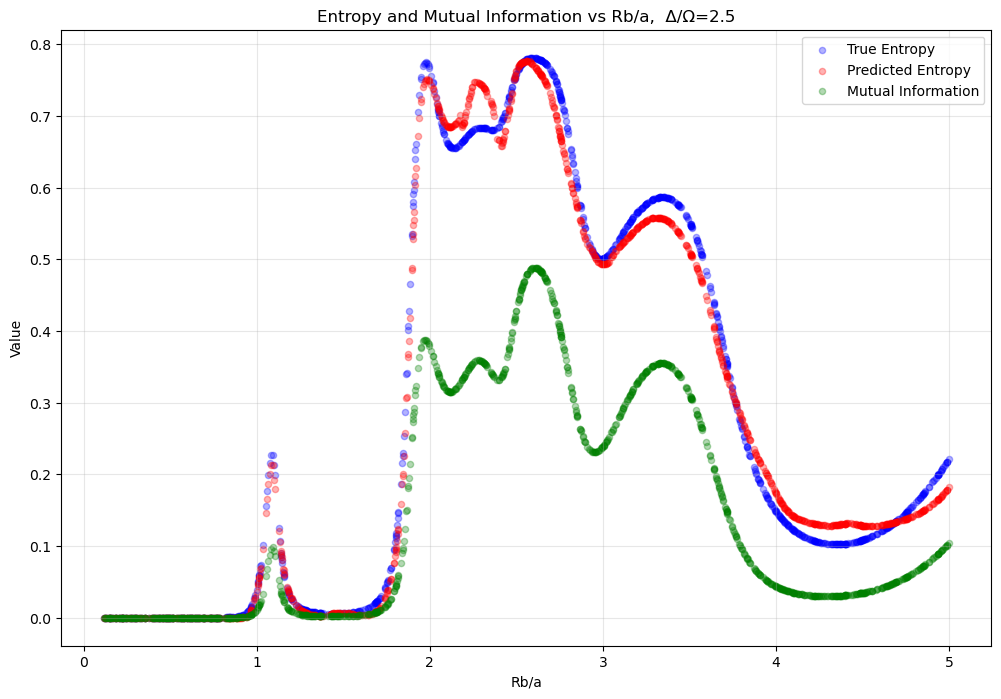

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from torch.serialization import safe_globals
from Train2_12 import ExperimentalGNN, SpinSystemDataset, PhysicalScaleAwareLoss

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'processed_dir': r'C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Size14\processed_experimentalrung7_delta2.5',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'hidden_channels': 512,
    'num_layers': 8,
    'dropout_p': 0.4
}


def load_data():
    return SpinSystemDataset(root=CONFIG['processed_dir'])


# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=6, dropout_p=0.4):
    """
    Loads the model state dict (which includes BatchNorm running stats),
    then calls model.eval() to ensure those stats are used (frozen).
    """
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    # IMPORTANT: model.eval() so that BatchNorm uses stored running_mean / running_var
    model.eval()
    return model

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_on_subset(model, dataset, N, batch_size=2048):
    subset = dataset[:N]  # Evaluate on first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    all_targets = []
    all_rb_over_a = []
    all_delta_over_omega = []
    all_mutual_info = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            
            targets = data.y.squeeze()                        
            rb_over_a = data.rb_over_a.squeeze(-1)            
            delta_over_omega = data.delta_over_omega.squeeze(-1)
            mutual_info = data.MI.squeeze(-1)
            
            all_preds.append(pred.cpu())
            all_targets.append(targets.cpu())
            all_rb_over_a.append(rb_over_a.cpu())
            all_delta_over_omega.append(delta_over_omega.cpu())
            all_mutual_info.append(mutual_info.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_rb_over_a = torch.cat(all_rb_over_a).numpy()
    all_delta_over_omega = torch.cat(all_delta_over_omega).numpy()
    all_mutual_info = torch.cat(all_mutual_info).numpy()
    
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_preds - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics on {N} graphs:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return all_preds, all_targets, all_rb_over_a, all_delta_over_omega, all_mutual_info

# -----------------------------------------------------------------------------
# Plotting Functions
# -----------------------------------------------------------------------------
def plot_results(preds, targets):
    residuals = targets - preds
    abs_errors = np.abs(residuals)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Predicted Entropy (S)')
    plt.title('True vs Predicted Entropy')
    plt.grid(True)
    plt.show()

def plot_2d_values_vs_rb_a(rb_over_a, targets, preds, mutual_info, 
                                save_fig=False, fig_filename='2d_plot.png'):
    """
    Create a 2D plot showing true entropy, predicted entropy, and mutual information
    against delta/omega values.
    """
    plt.figure(figsize=(12, 8))
    

    sort_idx = np.argsort(rb_over_a)
    rb_over_a = rb_over_a[sort_idx]
    targets = targets[sort_idx]
    preds = preds[sort_idx]
    mutual_info = mutual_info[sort_idx]
    
    # Plot each series
    plt.scatter(rb_over_a, targets, alpha=0.3, label='True Entropy', color='blue', s=20)
    plt.scatter(rb_over_a, preds, alpha=0.3, label='Predicted Entropy', color='red', s=20)
    plt.scatter(rb_over_a, mutual_info, alpha=0.3, label='Mutual Information', color='green', s=20)
    
    
    plt.xlabel('Rb/a')
    plt.ylabel('Value')
    plt.title('Entropy and Mutual Information vs Rb/a,  Δ/Ω=2.5')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_fig:
        plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {fig_filename}")
    else:
        plt.show()

def main():
    # Point to the model you trained with BatchNorm
    model_path = 'finetuned_model.pth'
    N = 50000  # Number of graphs to evaluate
    
    dataset = load_data()
    print(f"Dataset length: {len(dataset)}")
    
    # Load the trained model, which has BN statistics in state_dict
    model = load_trained_model(model_path)
    preds, targets, rb_over_a, delta_over_omega, mutual_info = evaluate_on_subset(model, dataset, N)
    
    # Create both plots
    plot_results(preds, targets)
    plot_2d_values_vs_rb_a(rb_over_a, targets, preds, mutual_info, save_fig=False)

if __name__ == "__main__":
    main()

Dataset length: 1000
Metrics on 50000 graphs:
  MSE: 0.003556
  MAE: 0.046622
  MAPE: 586572.41%


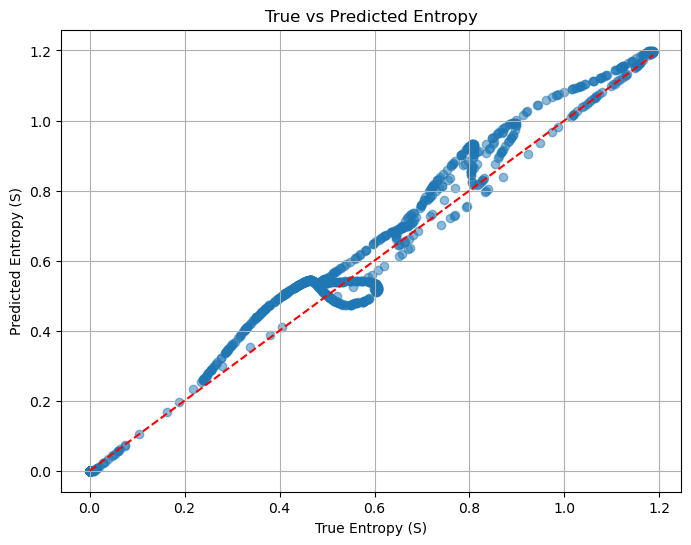

Plot saved as 1.png


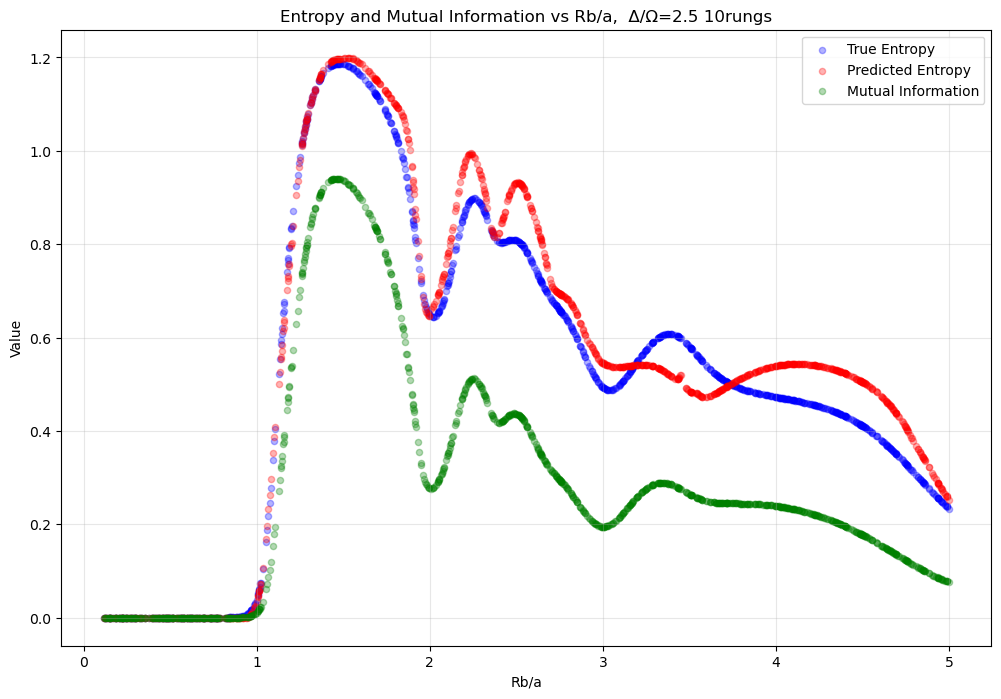

In [52]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from torch.serialization import safe_globals
from Train2_12 import ExperimentalGNN, SpinSystemDataset, PhysicalScaleAwareLoss

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'processed_dir': r'C:/Users/amssa/Documents/Codes/New/Von-Neumann-Entropy-GNN/Size14/processed_size10_2.5Delta_sym',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'hidden_channels': 512,
    'num_layers': 8,
    'dropout_p': 0.4
}


def load_data():
    return SpinSystemDataset(root=CONFIG['processed_dir'])


# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=6, dropout_p=0.4):
    """
    Loads the model state dict (which includes BatchNorm running stats),
    then calls model.eval() to ensure those stats are used (frozen).
    """
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    # IMPORTANT: model.eval() so that BatchNorm uses stored running_mean / running_var
    model.eval()
    return model

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_on_subset(model, dataset, N, batch_size=2048):
    subset = dataset[:N]  # Evaluate on first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    all_targets = []
    all_rb_over_a = []
    all_delta_over_omega = []
    all_mutual_info = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            
            targets = data.y.squeeze()                        
            rb_over_a = data.rb_over_a.squeeze(-1)            
            delta_over_omega = data.delta_over_omega.squeeze(-1)
            mutual_info = data.MI.squeeze(-1)
            
            all_preds.append(pred.cpu())
            all_targets.append(targets.cpu())
            all_rb_over_a.append(rb_over_a.cpu())
            all_delta_over_omega.append(delta_over_omega.cpu())
            all_mutual_info.append(mutual_info.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_rb_over_a = torch.cat(all_rb_over_a).numpy()
    all_delta_over_omega = torch.cat(all_delta_over_omega).numpy()
    all_mutual_info = torch.cat(all_mutual_info).numpy()
    
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_preds - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics on {N} graphs:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return all_preds, all_targets, all_rb_over_a, all_delta_over_omega, all_mutual_info

# -----------------------------------------------------------------------------
# Plotting Functions
# -----------------------------------------------------------------------------
def plot_results(preds, targets):
    residuals = targets - preds
    abs_errors = np.abs(residuals)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Predicted Entropy (S)')
    plt.title('True vs Predicted Entropy')
    plt.grid(True)
    plt.show()

def plot_2d_values_vs_rb_a(rb_over_a, targets, preds, mutual_info, 
                                save_fig=False, fig_filename='1.png'):
    """
    Create a 2D plot showing true entropy, predicted entropy, and mutual information
    against delta/omega values.
    """
    plt.figure(figsize=(12, 8))
    

    sort_idx = np.argsort(rb_over_a)
    rb_over_a = rb_over_a[sort_idx]
    targets = targets[sort_idx]
    preds = preds[sort_idx]
    mutual_info = mutual_info[sort_idx]
    
    # Plot each series
    plt.scatter(rb_over_a, targets, alpha=0.3, label='True Entropy', color='blue', s=20)
    plt.scatter(rb_over_a, preds, alpha=0.3, label='Predicted Entropy', color='red', s=20)
    plt.scatter(rb_over_a, mutual_info, alpha=0.3, label='Mutual Information', color='green', s=20)
    
    
    plt.xlabel('Rb/a')
    plt.ylabel('Value')
    plt.title('Entropy and Mutual Information vs Rb/a,  Δ/Ω=2.5 10rungs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_fig:
        plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {fig_filename}")
    else:
        plt.show()

def main():
    # Point to the model you trained with BatchNorm
    model_path = 'finetuned_model_9-10.pth'
    N = 50000  # Number of graphs to evaluate
    
    dataset = load_data()
    print(f"Dataset length: {len(dataset)}")
    
    # Load the trained model, which has BN statistics in state_dict
    model = load_trained_model(model_path)
    preds, targets, rb_over_a, delta_over_omega, mutual_info = evaluate_on_subset(model, dataset, N)
    
    # Create both plots
    plot_results(preds, targets)
    plot_2d_values_vs_rb_a(rb_over_a, targets, preds, mutual_info, save_fig=True)

if __name__ == "__main__":
    main()

Loading models...
Detected 6 layers in model from finetuned_model_0.5lr_1.5wd.pth
Detected 6 layers in model from finetuned_model_9-10.pth


Evaluating on dataset: Δ/Ω=3.5 9 rungs
Dataset length: 1000
Metrics for Fine Tuned Model(7-8) on Δ/Ω=3.5 9 rungs on 50000 graphs:
  MSE: 0.004540
  MAE: 0.037760
  MAPE: 6770658.59%
Metrics for Fine Tuned Model(9-10) on Δ/Ω=3.5 9 rungs on 50000 graphs:
  MSE: 0.003706
  MAE: 0.036649
  MAPE: 2036083.79%


Evaluating on dataset: Δ/Ω=3.5 10 rungs
Dataset length: 1000
Metrics for Fine Tuned Model(7-8) on Δ/Ω=3.5 10 rungs on 50000 graphs:
  MSE: 0.009515
  MAE: 0.064720
  MAPE: 10740772.66%
Metrics for Fine Tuned Model(9-10) on Δ/Ω=3.5 10 rungs on 50000 graphs:
  MSE: 0.008814
  MAE: 0.064195
  MAPE: 765990.82%

Generating grid plots...
Plot saved as results_comparison_grid.png
Plot saved as error_distribution_grid.png
Plot saved as rb_a_comparison_grid.png


           DATASET             |   MODEL 1 MSE   |   MODEL 2 MSE   |   MODEL 1 MAE   |   MODE

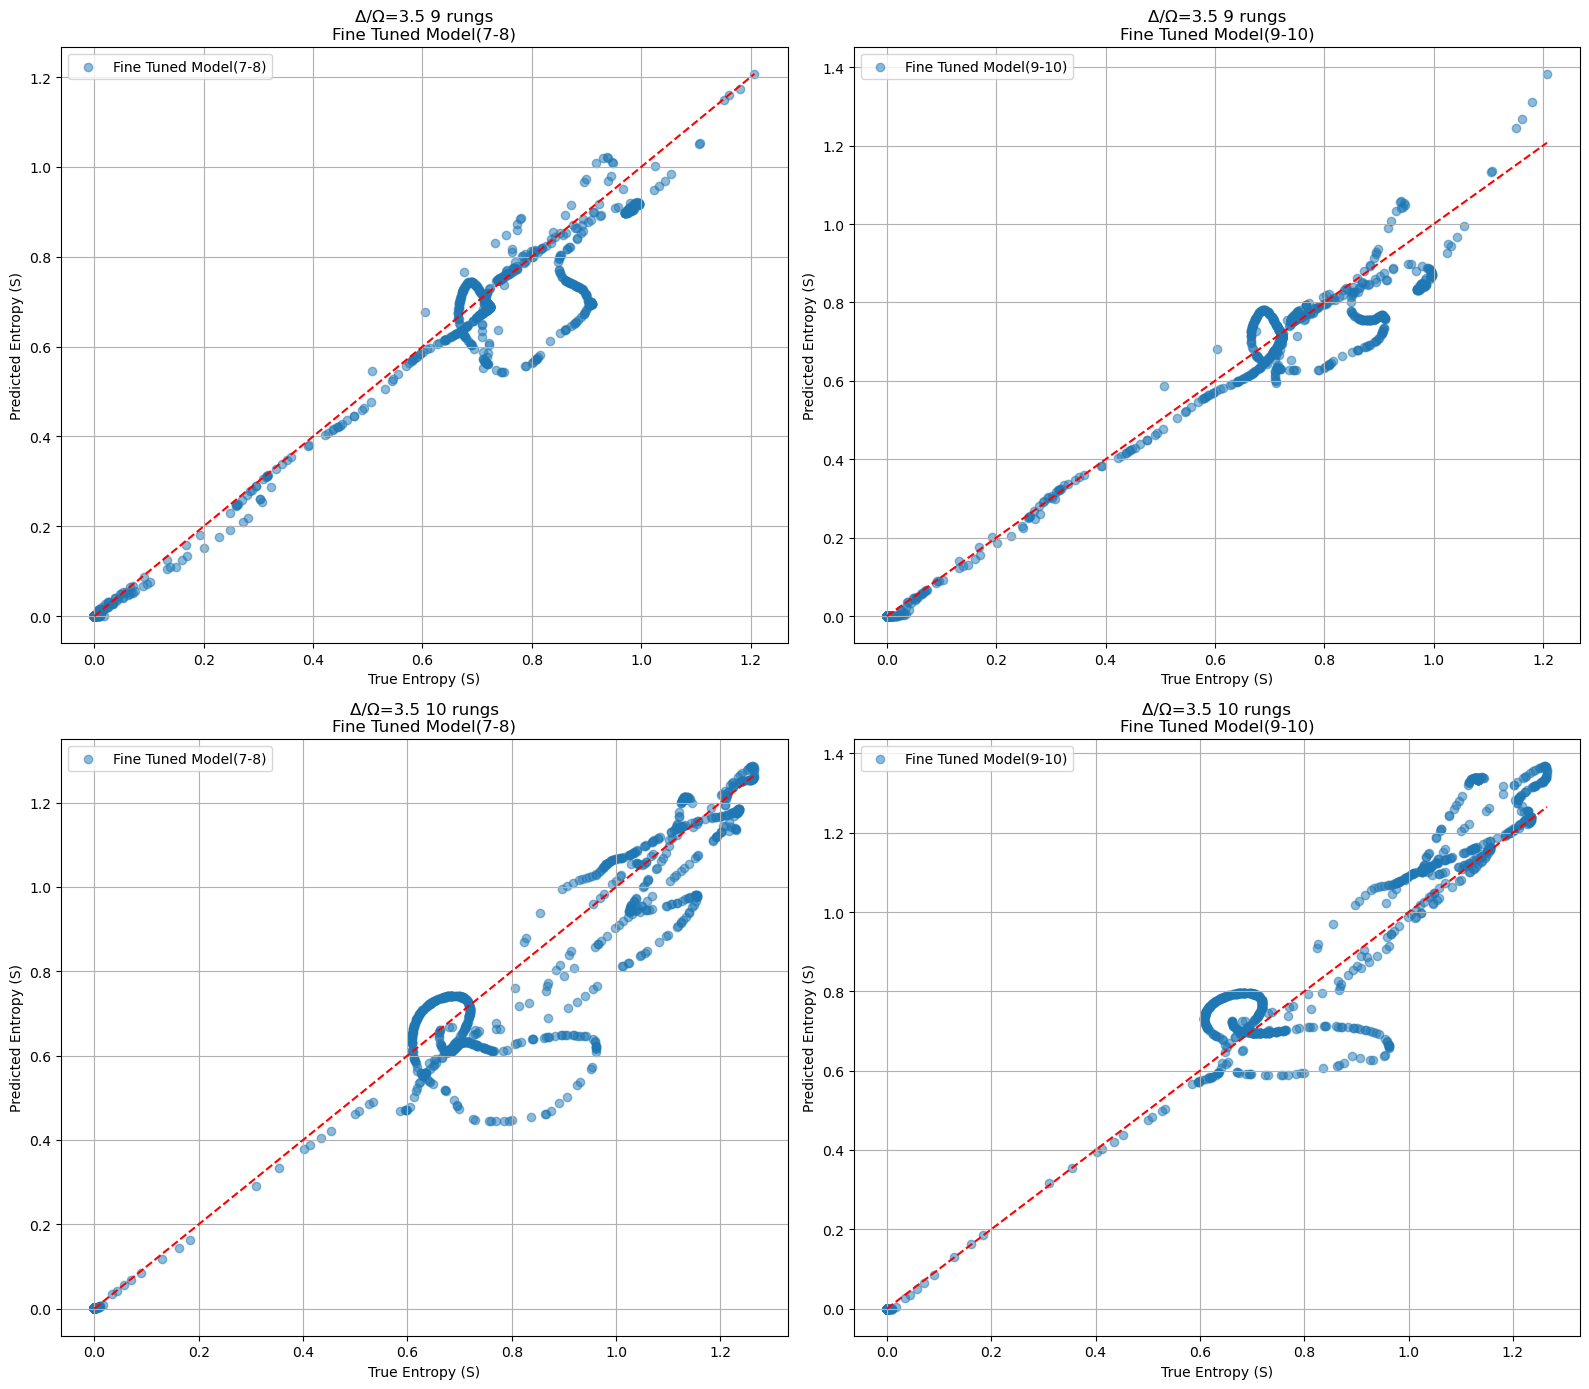

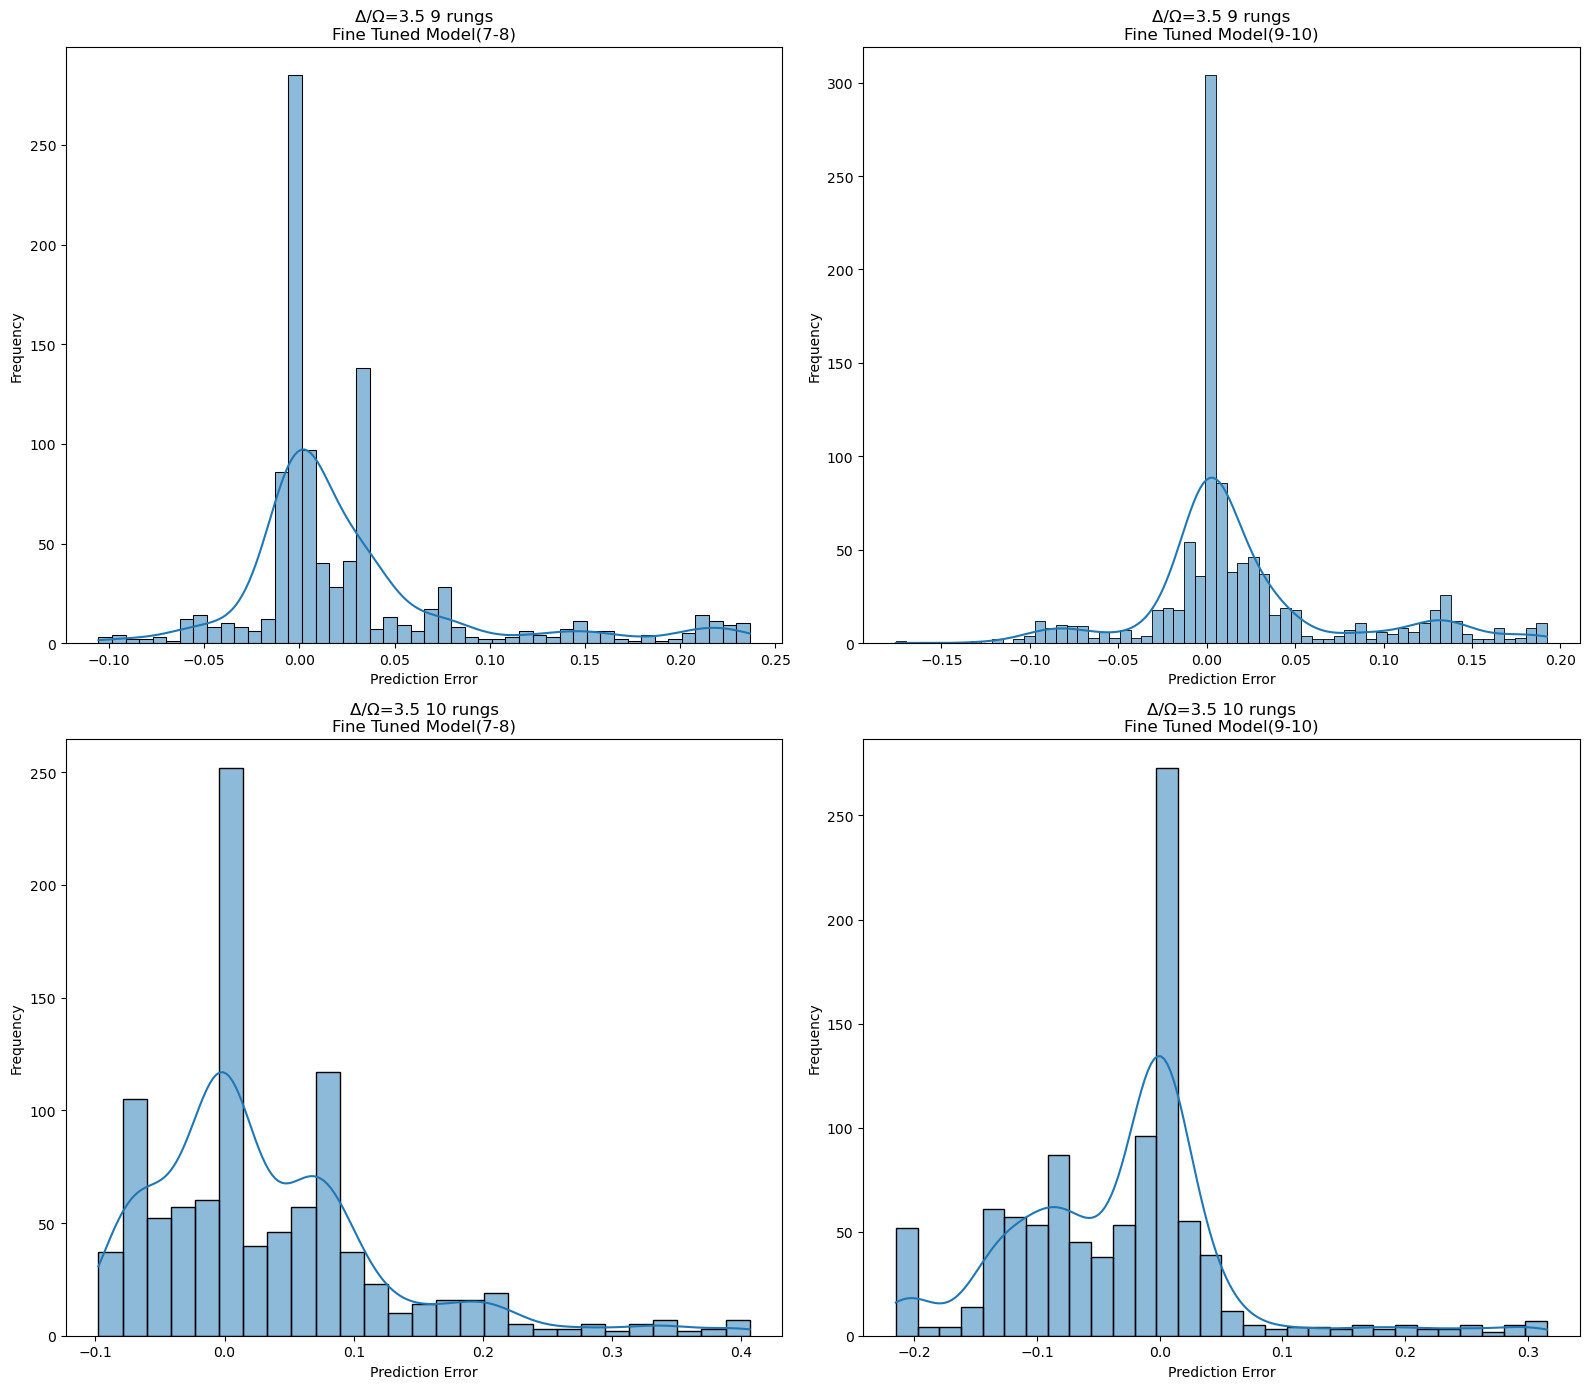

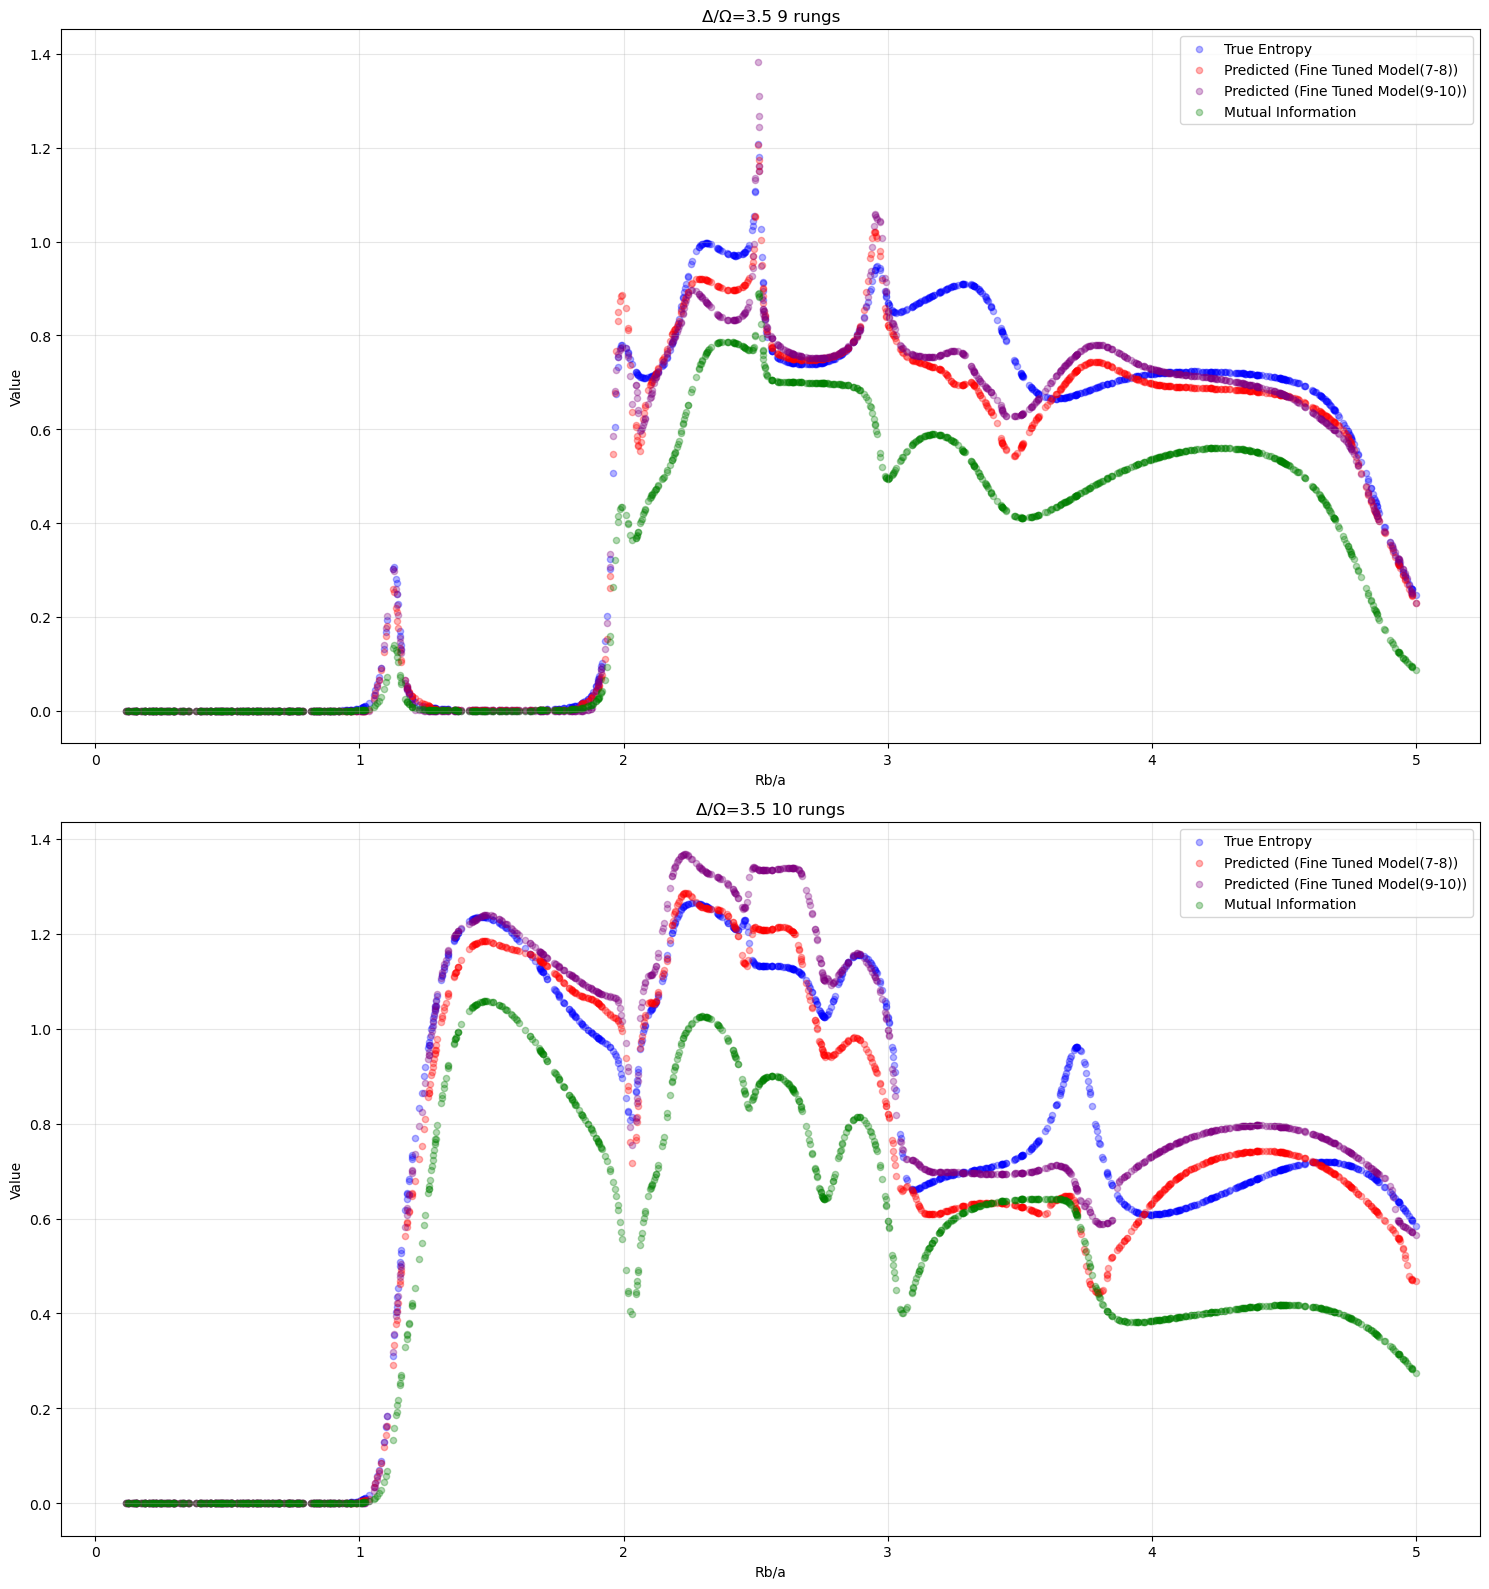

In [68]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm
)
from torch.serialization import safe_globals
from Train2_12 import ExperimentalGNN, SpinSystemDataset, PhysicalScaleAwareLoss

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'batch_size': 512,
    'hidden_channels': 512,
    'dropout_p': 0.4,
    # List of datasets to evaluate
    'datasets': [
        {
            'path': r'C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Testing\processed_Delta3.5_size9_r6',
            'name': 'Δ/Ω=3.5 9 rungs'
        },
        {
            'path': r'C:/Users/amssa/Documents/Codes/New/Von-Neumann-Entropy-GNN/Size14/processed_size10_3.5Delta_sym',
            'name': 'Δ/Ω=3.5 10 rungs'
        }


        # Add more datasets as needed
    ]
}


def load_data(dataset_path):
    return SpinSystemDataset(root=dataset_path)


# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=6, dropout_p=0.4):
    """
    Loads the model state dict (which includes BatchNorm running stats),
    then calls model.eval() to ensure those stats are used (frozen).
    First loads the state dict to check num_layers from the actual saved model.
    """
    # First load the state dict to determine correct model architecture
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    
    # Detect model structure from the loaded state dict
    max_layer_idx = -1
    for key in state_dict.keys():
        if key.startswith('convs.'):
            layer_idx = int(key.split('.')[1])
            max_layer_idx = max(max_layer_idx, layer_idx)
    
    # If we found layer indices, use them to determine actual num_layers
    if max_layer_idx >= 0:
        actual_num_layers = max_layer_idx + 1
        print(f"Detected {actual_num_layers} layers in model from {model_path}")
        num_layers = actual_num_layers
    
    # Create model with the correct number of layers
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    model.load_state_dict(state_dict)
    # IMPORTANT: model.eval() so that BatchNorm uses stored running_mean / running_var
    model.eval()
    return model

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_on_subset(model, dataset, N, batch_size=2048, model_name="Model"):
    subset = dataset[:N]  # Evaluate on first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    all_targets = []
    all_rb_over_a = []
    all_delta_over_omega = []
    all_mutual_info = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            
            targets = data.y.squeeze()                        
            rb_over_a = data.rb_over_a.squeeze(-1)            
            delta_over_omega = data.delta_over_omega.squeeze(-1)
            mutual_info = data.MI.squeeze(-1)
            
            all_preds.append(pred.cpu())
            all_targets.append(targets.cpu())
            all_rb_over_a.append(rb_over_a.cpu())
            all_delta_over_omega.append(delta_over_omega.cpu())
            all_mutual_info.append(mutual_info.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_rb_over_a = torch.cat(all_rb_over_a).numpy()
    all_delta_over_omega = torch.cat(all_delta_over_omega).numpy()
    all_mutual_info = torch.cat(all_mutual_info).numpy()
    
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_preds - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics for {model_name} on {N} graphs:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return all_preds, all_targets, all_rb_over_a, all_delta_over_omega, all_mutual_info

# -----------------------------------------------------------------------------
# Plotting Functions
# -----------------------------------------------------------------------------
def plot_results_comparison_grid(all_results, model1_name="Model 1", model2_name="Model 2", save_fig=False, fig_filename='results_grid.png'):
    """
    Create a grid of comparison scatter plots for both models across all datasets.
    all_results is a list of dictionaries, each containing results for one dataset.
    """
    num_datasets = len(all_results)
    fig, axes = plt.subplots(num_datasets, 2, figsize=(16, 7 * num_datasets))
    
    for i, result in enumerate(all_results):
        dataset_name = result['dataset_name']
        preds1, targets1 = result['preds1'], result['targets1']
        preds2, targets2 = result['preds2'], result['targets2']
        
        # Handle the case where there's only one dataset (axes would be 1D)
        if num_datasets == 1:
            ax1, ax2 = axes
        else:
            ax1, ax2 = axes[i]
        
        # Model 1
        ax1.scatter(targets1, preds1, alpha=0.5, label=model1_name)
        ax1.plot([min(targets1), max(targets1)], [min(targets1), max(targets1)], 'r--')
        ax1.set_xlabel('True Entropy (S)')
        ax1.set_ylabel('Predicted Entropy (S)')
        ax1.set_title(f'{dataset_name}\n{model1_name}')
        ax1.grid(True)
        ax1.legend()
        
        # Model 2
        ax2.scatter(targets2, preds2, alpha=0.5, label=model2_name)
        ax2.plot([min(targets2), max(targets2)], [min(targets2), max(targets2)], 'r--')
        ax2.set_xlabel('True Entropy (S)')
        ax2.set_ylabel('Predicted Entropy (S)')
        ax2.set_title(f'{dataset_name}\n{model2_name}')
        ax2.grid(True)
        ax2.legend()
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {fig_filename}")
    else:
        plt.show()

def plot_error_distribution_grid(all_results, model1_name="Model 1", model2_name="Model 2", save_fig=False, fig_filename='error_grid.png'):
    """
    Create a grid of error distribution plots for both models across all datasets.
    """
    num_datasets = len(all_results)
    fig, axes = plt.subplots(num_datasets, 2, figsize=(16, 7 * num_datasets))
    
    for i, result in enumerate(all_results):
        dataset_name = result['dataset_name']
        preds1, targets1 = result['preds1'], result['targets1']
        preds2, targets2 = result['preds2'], result['targets2']
        
        residuals1 = targets1 - preds1
        residuals2 = targets2 - preds2
        
        # Handle the case where there's only one dataset (axes would be 1D)
        if num_datasets == 1:
            ax1, ax2 = axes
        else:
            ax1, ax2 = axes[i]
        
        sns.histplot(residuals1, kde=True, ax=ax1)
        ax1.set_xlabel('Prediction Error')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'{dataset_name}\n{model1_name}')
        
        sns.histplot(residuals2, kde=True, ax=ax2)
        ax2.set_xlabel('Prediction Error')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'{dataset_name}\n{model2_name}')
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {fig_filename}")
    else:
        plt.show()

def plot_2d_values_vs_rb_a_grid(all_results, model1_name="Model 1", model2_name="Model 2", save_fig=True, fig_filename='rb_a_grid.png'):
    """
    Create a grid of rb/a comparison plots for both models across all datasets.
    """
    num_datasets = len(all_results)
    fig, axes = plt.subplots(num_datasets, 1, figsize=(15, 8 * num_datasets))
    
    for i, result in enumerate(all_results):
        dataset_name = result['dataset_name']
        rb_over_a = result['rb_over_a']
        targets = result['targets1']  # They're the same for both models
        preds1 = result['preds1']
        preds2 = result['preds2']
        mutual_info = result['mutual_info']
        
        # Handle the case where there's only one dataset (axes would be a single axis)
        if num_datasets == 1:
            ax = axes
        else:
            ax = axes[i]
        
        # Sort all arrays by rb_over_a
        sort_idx = np.argsort(rb_over_a)
        rb_over_a_sorted = rb_over_a[sort_idx]
        targets_sorted = targets[sort_idx]
        preds1_sorted = preds1[sort_idx]
        preds2_sorted = preds2[sort_idx]
        mutual_info_sorted = mutual_info[sort_idx]
        
        # Plot each series
        ax.scatter(rb_over_a_sorted, targets_sorted, alpha=0.3, label='True Entropy', color='blue', s=20)
        ax.scatter(rb_over_a_sorted, preds1_sorted, alpha=0.3, label=f'Predicted ({model1_name})', color='red', s=20)
        ax.scatter(rb_over_a_sorted, preds2_sorted, alpha=0.3, label=f'Predicted ({model2_name})', color='purple', s=20)
        ax.scatter(rb_over_a_sorted, mutual_info_sorted, alpha=0.3, label='Mutual Information', color='green', s=20)
        
        ax.set_xlabel('Rb/a')
        ax.set_ylabel('Value')
        ax.set_title(dataset_name)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {fig_filename}")
    else:
        plt.show()

def main():
    # Point to the models you want to compare
    model1_path = 'finetuned_model_0.5lr_1.5wd.pth'
    model2_path =  'finetuned_model_9-10.pth' # Replace with your second model path
    model1_name = "Fine Tuned Model(7-8)"
    model2_name = "Fine Tuned Model(9-10)"
    
    N = 50000  # Number of graphs to evaluate per dataset
    
    # Load the models once - will auto-detect correct architecture
    print(f"Loading models...")
    model1 = load_trained_model(model1_path)
    model2 = load_trained_model(model2_path)
    
    # Store all results in a list for grid plotting
    all_results = []
    all_metrics = []
    
    # Evaluate each dataset
    for dataset_config in CONFIG['datasets']:
        dataset_path = dataset_config['path']
        dataset_name = dataset_config['name']
        
        print(f"\n\n{'='*80}")
        print(f"Evaluating on dataset: {dataset_name}")
        print(f"{'='*80}")
        
        # Load the dataset
        dataset = load_data(dataset_path)
        print(f"Dataset length: {len(dataset)}")
        
        # Evaluate both models on this dataset
        preds1, targets1, rb_over_a1, delta_over_omega1, mutual_info1 = evaluate_on_subset(
            model1, dataset, N, model_name=f"{model1_name} on {dataset_name}"
        )
        
        preds2, targets2, rb_over_a2, delta_over_omega2, mutual_info2 = evaluate_on_subset(
            model2, dataset, N, model_name=f"{model2_name} on {dataset_name}"
        )
        
        # Calculate metrics
        mse1 = mean_squared_error(targets1, preds1)
        mse2 = mean_squared_error(targets2, preds2)
        mae1 = mean_absolute_error(targets1, preds1)
        mae2 = mean_absolute_error(targets2, preds2)
        
        # Store metrics
        all_metrics.append({
            'dataset_name': dataset_name,
            'model1_mse': mse1,
            'model2_mse': mse2,
            'model1_mae': mae1,
            'model2_mae': mae2,
            'better_model': model1_name if mse1 < mse2 else model2_name
        })
        
        # Store results for plotting
        all_results.append({
            'dataset_name': dataset_name,
            'preds1': preds1,
            'targets1': targets1,
            'preds2': preds2,
            'targets2': targets2,
            'rb_over_a': rb_over_a1,
            'delta_over_omega': delta_over_omega1,
            'mutual_info': mutual_info1
        })
    
    # Create grid plots for all datasets
    print("\nGenerating grid plots...")
    plot_results_comparison_grid(all_results, model1_name, model2_name, save_fig=True, fig_filename='results_comparison_grid.png')
    plot_error_distribution_grid(all_results, model1_name, model2_name, save_fig=True, fig_filename='error_distribution_grid.png')
    plot_2d_values_vs_rb_a_grid(all_results, model1_name, model2_name, save_fig=True, fig_filename='rb_a_comparison_grid.png')
    
    # Print summary metrics table
    print("\n\n" + "="*100)
    print(f"{'DATASET':^30} | {'MODEL 1 MSE':^15} | {'MODEL 2 MSE':^15} | {'MODEL 1 MAE':^15} | {'MODEL 2 MAE':^15} | {'BETTER MODEL':^10}")
    print("="*100)
    
    for metric in all_metrics:
        print(f"{metric['dataset_name']:^30} | {metric['model1_mse']:^15.6f} | {metric['model2_mse']:^15.6f} | "
              f"{metric['model1_mae']:^15.6f} | {metric['model2_mae']:^15.6f} | {metric['better_model']:^10}")
    
    print("="*100)

if __name__ == "__main__":
    main()